# <p><center style="font-family:cursive; color:orange;font-size:200%;">Big Cats of the Wild - Image Classification | Acc=93%</center></p>

<p style="padding: 50px;
              color:white;">Overview: This personal project stems from my profound fascination with the enchanting beauty of wild cats. The inspiration for this endeavor traces back to my childhood, where I encountered challenges in distinguishing between various breeds of wild cats. Although, this may not pose a challenge today, I recognize that many wildlife enthusiasts encounter similar hurdles. Drawing a parallel with bird identification, where the vast number of species (over 11,000 species) can pose a serious challenge. This project seeks to address such challenges through the transformative power of technology. By developing and implementing image classification systems, specifically utilizing deep learning algorithms. The aim is to provide a solution for effortlessly classifying images of cheetahs, leopards, lions, and tigers. Thereby, showcasing the ability of Convolutional Nueral Networks (CNN) which can also translate into more sophisticated AI models for the identification of different animal species.

</p>

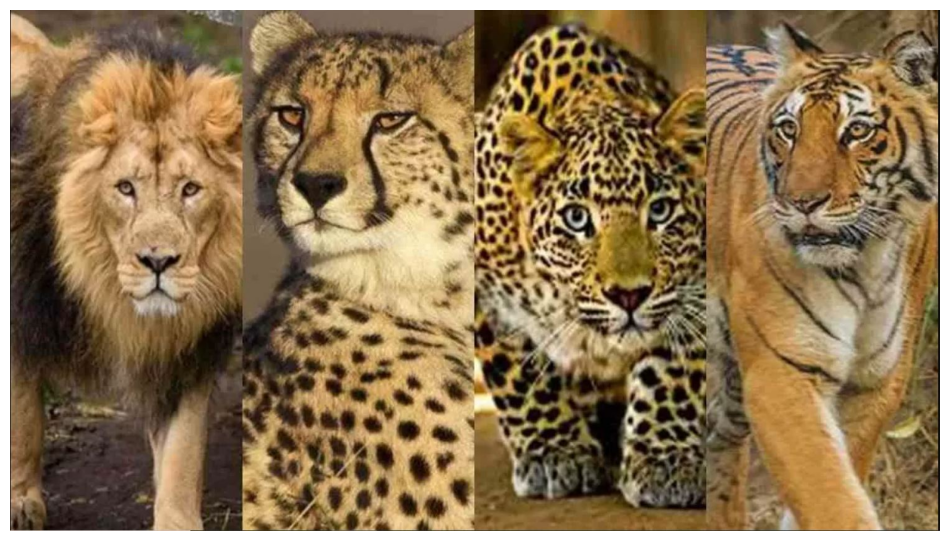

In [ ]:
# @title Wild Cats
image_path = "/content/drive/MyDrive/CNN_Project_Images/cllt.JPG"
# Set the figure size (adjust these values as needed)
fig, ax = plt.subplots(figsize=(12,8))
# Display the image
ax.imshow(plt.imread(image_path))
ax.axis('off')
plt.show()

##<b>Objectives of Project</b><br><br>
This project aims to:</p>
<ul style="font-family:Georgia;padding:0px 50px 0px 50px;line-height:30px">
   <li>Preprocess images with ImageDataGenerator</li>
   <li>Employ Early Stopping and Reduction Learning Rate to our CNN model</li>
   <li>Employ Exponential Decay</li>
   <li>Compare predictive power among different Transfer Learning Models</li>
   <li>Analyse accuracy using Confusion Matrix</li>
   <li>Visualize results</li>
</ul>

Download Images from: https://drive.google.com/drive/folders/1fKNDQtae--TJYv5Qw05W4XfFj2Korf-K?usp=drive_link

In [ ]:
# @title Importing Libraries
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
import random

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing

# Model Architecture
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import MobileNetV2

# System libraries
from pathlib import Path
import os.path

# Visualization Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Model Hypertunning
!pip install -q keras_tuner
import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [ ]:
# @title Getting the paths for train, test and validation set
train_path = '/content/drive/MyDrive/CNN_Project_Images/Train'
test_path = '/content/drive/MyDrive/CNN_Project_Images/Test'
valid_path = '/content/drive/MyDrive/CNN_Project_Images/Valid'

### Data Augmentation

<u>What is Data Augmentation?</u>
<p>Data augmentation is a set of techniques that enhance the size and quality of machine learning training datasets so that better deep learning models can be trained with them.</p>

<u>Purpose of Data Augmentation:</u>
<ul>
   <li>Reduced Overfitting: Augmenting the training data with diverse transformations helps prevent the model from memorizing specific patterns in the training set that might not be relevant to the overall task. This can reduce overfitting, where the model performs well on the training data but poorly on new, unseen data.</li>
   <li>Increased Dataset Size: By applying random transformations to the existing images, you effectively increase the size of your training dataset. This is particularly useful when the original dataset is limited, as a larger dataset often helps in training more robust models.</li>
   <li>Improved Generalization: Data augmentation helps the model become invariant to certain transformations, such as rotation, scaling, and flipping. This makes the model more capable of handling variations in the input data during the testing phase, resulting in better generalization to new, unseen data.</li>
</ul>

In [ ]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

# data augmentation for testing
test_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

# data augmentation for validation
valid_datagen = ImageDataGenerator(rescale=1.0/255)  # Rescale pixel values to [0, 1]

In [ ]:
# @title Declaring image size and batch size for training CNN
images_size = 224 # Declaring the sizes the images need to be processed in
batch_size = 16 # Declaring batch size for CNN training

In [ ]:
# @title Load the Images with a generator
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(images_size, images_size),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)


# Create a generator for testing data
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')


# Create a generator for validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(images_size, images_size),
    batch_size = batch_size,
    class_mode='categorical')

Found 1476 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


<p>flow_from_directory: Method is used for generating batches of images and their labels directly from a directory structure. This is particularly useful when dealing with large datasets that are organized into subdirectories, where each subdirectory represents a class or category.</p>

## Visualizing Data Distribution
<p>
 Class distribution plays a critical role in both the model training process and our overall understanding of the dataset. <b>If the data is imbalanced, with some classes having significantly more samples than others</b>, <b>our model's results may be similarly imbalanced and biased towards the more heavily populated classes</b>
</p>

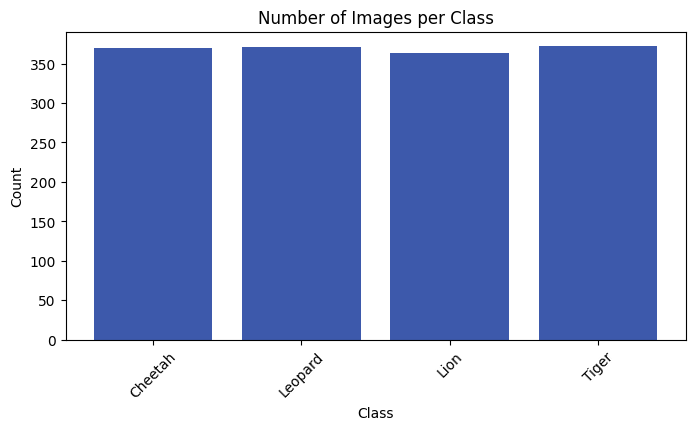

In [ ]:
# @title Training Set Distribution
# Get the class labels
class_labels=[str(label) for label in train_generator.class_indices.keys()]   # Extract the image labels


# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}    # initialize count for each label

for i in range(len(train_generator)):
    batch_data, batch_labels = train_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define color for barchart
bar_color = '#3D59AB'

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=bar_color)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)


plt.show()

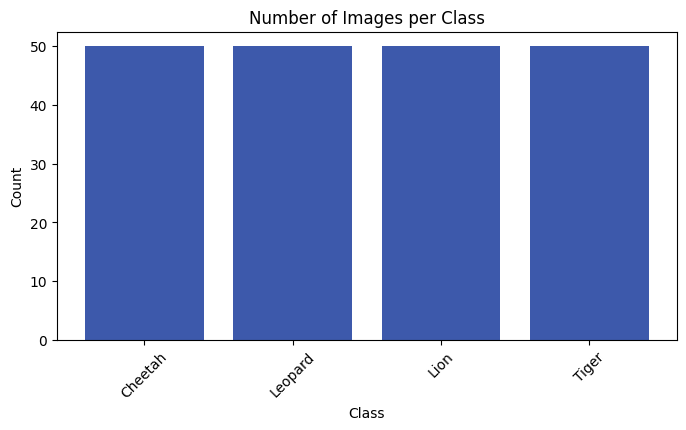

In [ ]:
# @title Test Set Distribution
# Get the class labels
class_labels=[str(label).split('_')[0] for label in test_generator.class_indices.keys()]

# Calculate the count of images per class
class_counts = {label: 0 for label in class_labels}

for i in range(len(test_generator)):
    batch_data, batch_labels = test_generator[i]
    for j in range(len(batch_data)):
        class_idx = int(batch_labels[j].argmax())
        class_label = class_labels[class_idx]
        class_counts[class_label] += 1

# Define color for barchart
bar_color = '#3D59AB'

# Create a bar chart with different colors for each class
plt.figure(figsize=(8, 4))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=bar_color)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Images per Class')
plt.xticks(rotation=45)


plt.show()

Cheetahs Train Images:


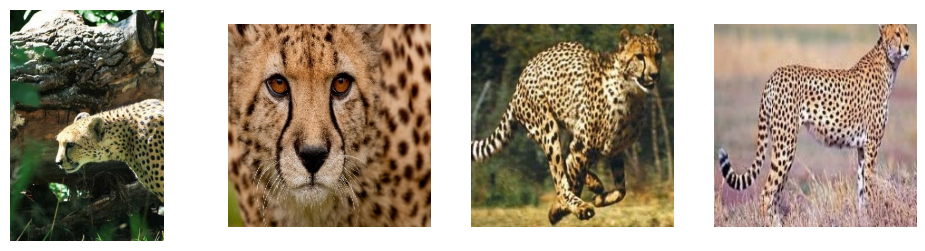

Leopards Train Images:


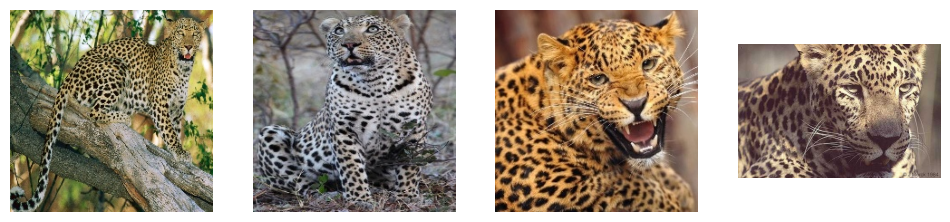

Lions Train Images:


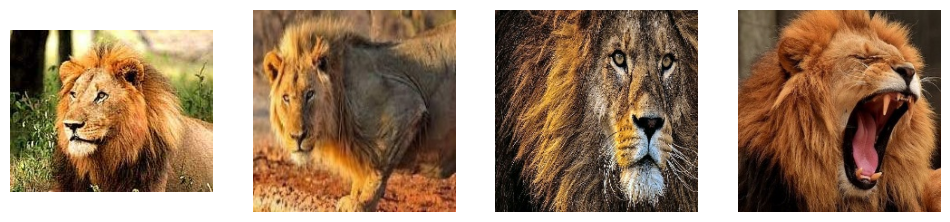

Tigers Train Images:


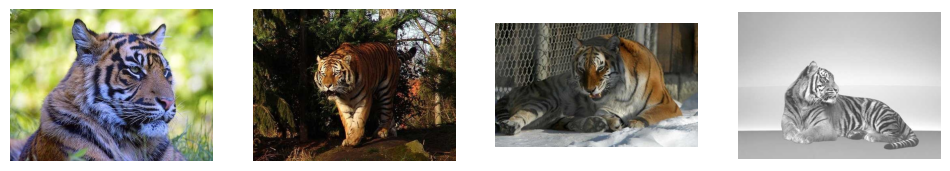

In [ ]:
# @title Visualizing Training Data (Randomly Generated From Training Set)

# Displaying 4 random images from train set for Each Class
# For Cheetahs
path_train_cheetah = '/content/drive/MyDrive/CNN_Project_Images/Train/Cheetah'
contents_cheetah = os.listdir(path_train_cheetah)
random_contents_cheetah = random.sample(contents_cheetah, min(4, len(contents_cheetah)))
random_contents_cheetah_list = [path_train_cheetah + '/' + str(i) for i in random_contents_cheetah]
print('Cheetahs Train Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_cheetah_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Leopards
path_train_leopard = '/content/drive/MyDrive/CNN_Project_Images/Train/Leopard'
contents_leopard = os.listdir(path_train_leopard)
random_contents_leopard = random.sample(contents_leopard, min(4, len(contents_leopard)))
random_contents_leopard_list = [path_train_leopard + '/' + str(i) for i in random_contents_leopard]
print('Leopards Train Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_leopard_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Lions
path_train_lion = '/content/drive/MyDrive/CNN_Project_Images/Train/Lion'
contents_lion = os.listdir(path_train_lion)
random_contents_lion = random.sample(contents_lion, min(4, len(contents_lion)))
random_contents_lion_list = [path_train_lion + '/' + str(i) for i in random_contents_lion]
print('Lions Train Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_lion_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Tigers
path_train_tiger = '/content/drive/MyDrive/CNN_Project_Images/Train/Tiger'
contents_tiger = os.listdir(path_train_tiger)
random_contents_tiger = random.sample(contents_tiger, min(4, len(contents_tiger)))
random_contents_tiger_list = [path_train_tiger + '/' + str(i) for i in random_contents_tiger]
print('Tigers Train Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_tiger_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

Cheetahs Test Images:


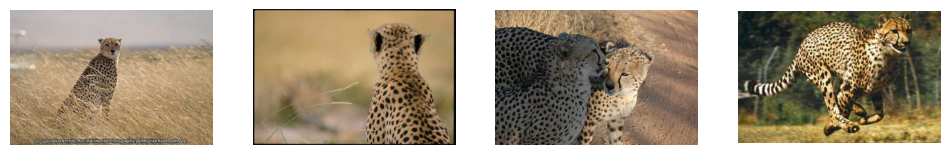

Leopards Test Images:


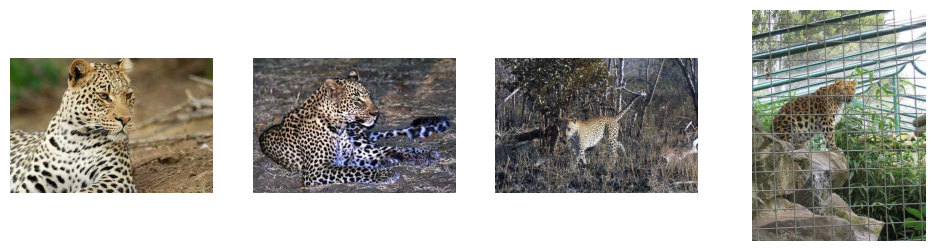

Lions Test Images:


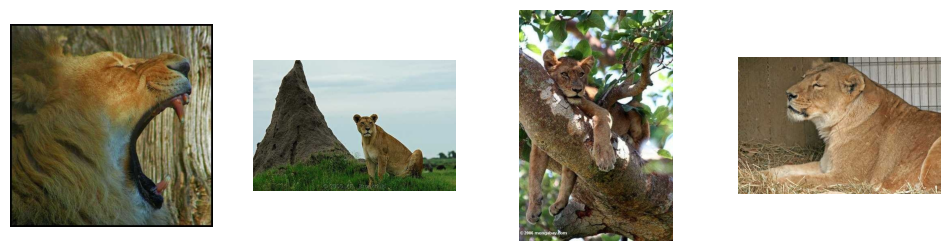

Tigers Test Images:


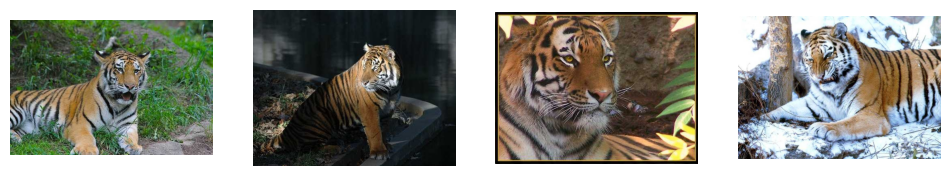

In [ ]:
# @title Visualizing Test Data (Randomly Generated From Test Set)
# Displaying random images from test set for Each Class

# For Cheetahs
path_train_cheetah = '/content/drive/MyDrive/CNN_Project_Images/Test/Cheetah'
contents_cheetah = os.listdir(path_train_cheetah)
random_contents_cheetah = random.sample(contents_cheetah, min(4, len(contents_cheetah)))
random_contents_cheetah_list = [path_train_cheetah + '/' + str(i) for i in random_contents_cheetah]
print('Cheetahs Test Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_cheetah_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Leopards
path_train_leopard = '/content/drive/MyDrive/CNN_Project_Images/Test/Leopard'
contents_leopard = os.listdir(path_train_leopard)
random_contents_leopard = random.sample(contents_leopard, min(4, len(contents_leopard)))
random_contents_leopard_list = [path_train_leopard + '/' + str(i) for i in random_contents_leopard]
print('Leopards Test Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_leopard_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Lions
path_train_lion = '/content/drive/MyDrive/CNN_Project_Images/Test/Lion'
contents_lion = os.listdir(path_train_lion)
random_contents_lion = random.sample(contents_lion, min(4, len(contents_lion)))
random_contents_lion_list = [path_train_lion + '/' + str(i) for i in random_contents_lion]
print('Lions Test Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_lion_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

# For Tigers
path_train_tiger = '/content/drive/MyDrive/CNN_Project_Images/Test/Tiger'
contents_tiger = os.listdir(path_train_tiger)
random_contents_tiger = random.sample(contents_tiger, min(4, len(contents_tiger)))
random_contents_tiger_list = [path_train_tiger + '/' + str(i) for i in random_contents_tiger]
print('Tigers Test Images:')
plt.figure(figsize=(12,3))
for i,j in enumerate(random_contents_tiger_list):
  plt.subplot(1,4,i+1)
  img=mpimg.imread(j)
  plt.imshow(img)
  plt.axis('off')
plt.show()

In [ ]:
# @title Early Stopping
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

<p>The <u>EarlyStopping()</u> callback is typically used when training a model with a validation set. It monitors a specified metric (e.g., validation loss) during training and stops the training process early if there is no improvement, thus preventing the model from overfitting to the training data. This is particularly useful in situations where training for too many epochs might lead to worse generalization on unseen data.

In [ ]:
# @title Default Reduction of Learning Rate
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

<p>ReduceLROnPlateau callback is used to dynamically adjust the learning rate during training based on the performance of the model on a specified metric (in this case, validation accuracy). This can help improve the convergence of the model by allowing it to adapt its learning rate in response to the training progress.</p>


# Exponential Decay

***ExponentialDecay*** **is a learning rate schedule** that reduces the learning rate exponentially over time. This is done by multiplying the learning rate by a factor of less than 1, such as 0.5 or 0.9, after a certain number of epochs or training steps.

The formula for exponential decay can be expressed as:

######  ***New Value = Initial Value × Decay Rate ^(Step Count)***


 For example, if you start with an initial learning rate of `0.1` and use an exponential decay rate of `0.9`, the learning rate might evolve as follows:

- After 1 step: \(0.1 \times 0.9^1 = 0.09\)
- After 2 steps: \(0.1 \times 0.9^2 = 0.081\)
- After 3 steps: \(0.1 \times 0.9^3 = 0.0729\)
- ...


ExponentialDecay is a common and effective learning rate schedule **for image classification**. It is often used in conjunction with other techniques, such as momentum and weight decay, **to improve the performance of deep learning models.**

**Benefits** of using `ExponentialDecay`:

* It can help to **prevent overfitting** by reducing the learning rate over time.
* It can help the model to converge **more quickly and smoothly.**
* It can help to **improve the fine-tuning** performance of the model.

However, there are also some **potential drawbacks** to using` ExponentialDecay`:

* It can be **difficult to choose the right initial learning rate and decay rate.**
* It can be **slow to converge in the early stages of training.**

In [ ]:
from tensorflow.keras import optimizers

# Create a learning rate schedule using Exponential Decay
learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  # Initial learning rate for training
    decay_steps=1000,            # Number of steps before decaying the learning rate
    decay_rate=0.5,              # Rate at which the learning rate decreases
)

# learning_rate = initial_learning_rate * decay_rate ^ (global_step / decay_steps)


In [ ]:
from keras.callbacks import LearningRateScheduler

# Create a Learning Rate Scheduler callback using a pre-defined schedule
lr_callback = LearningRateScheduler(learning_rate_schedule)
callback=[ lr_callback , learning_rate_reduce ,early_stopping ]

<p>A callback is a set of functions that can be applied at various stages of training a model. Callbacks are useful for customizing the behavior of a machine learning model during the training process without modifying the model architecture itself. They can perform actions such as adjusting the learning rate, saving model checkpoints, logging information, or stopping training based on certain conditions.</p>

# Comparison of Different Transfer Learning Models
<p>In this section, we aim to compare different TL Models architectures to determine which one performs best on our dataset. we will first collect a small subset of the data and train a basic model architecture on it. then we will analyze the performance of these TL Models and choose the best one</p>

In [ ]:
# Collect all TL models
TL_Models =[
    ResNet50V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    ResNet152V2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    InceptionV3(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    Xception(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
    MobileNetV2(input_shape=(images_size, images_size, 3), weights='imagenet', include_top=False),
]

# Define all the TL models names. This will be later used during visualization
TL_Models_NAMES = [
    'ResNet50V2',
    'ResNet152V2',
    'InceptionV3',
    'Xception',
    'MobileNetV2',
]

# Freeze the weights of all the TL models
for tl_model in TL_Models:
    tl_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# @title Creating Subset of Training Data
# Create variables to collect images and labels
subset_images = []
subset_labels = []

# Set the desired number of images you want in the subset
desired_count = 1000

# Loop through the generator until you have collected the desired number of images
for i in range(desired_count):
    # Generate a batch of data (images and labels)
    batch = train_generator.next()
    images, labels = batch
    subset_images.extend(images)
    subset_labels.extend(labels)

    # Check if you've collected enough images
    if len(subset_images) >= desired_count:
        break

# Convert the collected images and labels to numpy arrays
X_sub = np.array(subset_images)
y_sub = np.array(subset_labels)

In [ ]:
# @title Training the different TL Models
# Initialize an empty list to hold the histories of each TL_models architecture.
HISTORIES = []

# Loop over every backbone in the BACKBONES list.
for tl_model in tqdm(TL_Models, desc="Training Tl Models"):

    # Create the simplest model architecture using the current backbone.
    model = keras.Sequential([
        tl_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])

    # Compile the model with the specified loss function, optimizer, and metrics.
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate = learning_rate_schedule),
        metrics='accuracy'
    )

    # Train the model on a subset of the training data.
    history = model.fit(
        X_sub, y_sub,
        epochs=20,
        validation_split=0.2,
        batch_size=batch_size
    )

    # Store the history of the trained model.
    HISTORIES.append(history.history)

Training Tl Models:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/20
51/51 [==============================] - 190s 4s/step - loss: 0.6357 - accuracy: 0.8524 - val_loss: 0.2418 - val_accuracy: 0.9604
Epoch 2/20
51/51 [==============================] - 180s 4s/step - loss: 0.2652 - accuracy: 0.9578 - val_loss: 0.2560 - val_accuracy: 0.9010
Epoch 3/20
51/51 [==============================] - 176s 3s/step - loss: 0.1999 - accuracy: 0.9529 - val_loss: 0.1789 - val_accuracy: 0.9505
Epoch 4/20
51/51 [==============================] - 180s 4s/step - loss: 0.1835 - accuracy: 0.9541 - val_loss: 0.2118 - val_accuracy: 0.9703
Epoch 5/20
51/51 [==============================] - 172s 3s/step - loss: 0.1287 - accuracy: 0.9628 - val_loss: 0.1718 - val_accuracy: 0.9653
Epoch 6/20
51/51 [==============================] - 181s 4s/step - loss: 0.1069 - accuracy: 0.9653 - val_loss: 0.1567 - val_accuracy: 0.9752
Epoch 7/20
51/51 [==============================] - 180s 4s/step - loss: 0.1183 - accuracy: 0.9640 - val_loss: 0.1129 - val_accuracy: 0.9802
Epoch 8/20
51

Training Tl Models:  20%|██        | 1/5 [1:00:33<4:02:13, 3633.31s/it]

Epoch 1/20
51/51 [==============================] - 558s 11s/step - loss: 0.4363 - accuracy: 0.8859 - val_loss: 0.1949 - val_accuracy: 0.9455
Epoch 2/20
51/51 [==============================] - 543s 11s/step - loss: 0.2969 - accuracy: 0.9504 - val_loss: 0.2510 - val_accuracy: 0.9604
Epoch 3/20
51/51 [==============================] - 541s 11s/step - loss: 0.1547 - accuracy: 0.9677 - val_loss: 0.1695 - val_accuracy: 0.9653
Epoch 4/20
51/51 [==============================] - 541s 11s/step - loss: 0.1522 - accuracy: 0.9702 - val_loss: 0.2406 - val_accuracy: 0.9455
Epoch 5/20
51/51 [==============================] - 542s 11s/step - loss: 0.1586 - accuracy: 0.9690 - val_loss: 0.2385 - val_accuracy: 0.9455
Epoch 6/20
51/51 [==============================] - 531s 10s/step - loss: 0.1044 - accuracy: 0.9814 - val_loss: 0.3960 - val_accuracy: 0.9554
Epoch 7/20
51/51 [==============================] - 530s 10s/step - loss: 0.1318 - accuracy: 0.9727 - val_loss: 0.3775 - val_accuracy: 0.9455
Epoch 

Training Tl Models:  40%|████      | 2/5 [3:57:10<6:26:28, 7729.64s/it]

Epoch 1/20
51/51 [==============================] - 150s 3s/step - loss: 0.5642 - accuracy: 0.8809 - val_loss: 0.2786 - val_accuracy: 0.9257
Epoch 2/20
51/51 [==============================] - 139s 3s/step - loss: 0.1737 - accuracy: 0.9690 - val_loss: 0.1405 - val_accuracy: 0.9703
Epoch 3/20
51/51 [==============================] - 140s 3s/step - loss: 0.2022 - accuracy: 0.9640 - val_loss: 0.2102 - val_accuracy: 0.9653
Epoch 4/20
51/51 [==============================] - 139s 3s/step - loss: 0.1476 - accuracy: 0.9727 - val_loss: 0.3282 - val_accuracy: 0.9455
Epoch 5/20
51/51 [==============================] - 143s 3s/step - loss: 0.2102 - accuracy: 0.9690 - val_loss: 0.2585 - val_accuracy: 0.9554
Epoch 6/20
51/51 [==============================] - 140s 3s/step - loss: 0.1254 - accuracy: 0.9764 - val_loss: 0.2845 - val_accuracy: 0.9653
Epoch 7/20
51/51 [==============================] - 140s 3s/step - loss: 0.0993 - accuracy: 0.9777 - val_loss: 0.4982 - val_accuracy: 0.9356
Epoch 8/20
51

Training Tl Models:  60%|██████    | 3/5 [4:42:42<3:01:35, 5447.81s/it]

Epoch 1/20
51/51 [==============================] - 267s 5s/step - loss: 0.2875 - accuracy: 0.9132 - val_loss: 0.0985 - val_accuracy: 0.9554
Epoch 2/20
51/51 [==============================] - 260s 5s/step - loss: 0.1198 - accuracy: 0.9690 - val_loss: 0.0922 - val_accuracy: 0.9752
Epoch 3/20
51/51 [==============================] - 261s 5s/step - loss: 0.0798 - accuracy: 0.9789 - val_loss: 0.1201 - val_accuracy: 0.9703
Epoch 4/20
51/51 [==============================] - 263s 5s/step - loss: 0.1030 - accuracy: 0.9690 - val_loss: 0.1547 - val_accuracy: 0.9703
Epoch 5/20
51/51 [==============================] - 261s 5s/step - loss: 0.1314 - accuracy: 0.9764 - val_loss: 0.1415 - val_accuracy: 0.9653
Epoch 6/20
51/51 [==============================] - 226s 4s/step - loss: 0.0896 - accuracy: 0.9851 - val_loss: 0.1414 - val_accuracy: 0.9752
Epoch 7/20
51/51 [==============================] - 260s 5s/step - loss: 0.0399 - accuracy: 0.9926 - val_loss: 0.1313 - val_accuracy: 0.9703
Epoch 8/20
51

Training Tl Models:  80%|████████  | 4/5 [6:08:24<1:28:47, 5327.14s/it]

Epoch 1/20
51/51 [==============================] - 43s 772ms/step - loss: 0.6306 - accuracy: 0.8189 - val_loss: 0.3972 - val_accuracy: 0.9010
Epoch 2/20
51/51 [==============================] - 35s 697ms/step - loss: 0.2634 - accuracy: 0.9218 - val_loss: 0.2536 - val_accuracy: 0.9505
Epoch 3/20
51/51 [==============================] - 37s 738ms/step - loss: 0.1951 - accuracy: 0.9417 - val_loss: 0.2090 - val_accuracy: 0.9307
Epoch 4/20
51/51 [==============================] - 38s 754ms/step - loss: 0.2104 - accuracy: 0.9479 - val_loss: 0.3892 - val_accuracy: 0.9257
Epoch 5/20
51/51 [==============================] - 36s 710ms/step - loss: 0.2723 - accuracy: 0.9231 - val_loss: 0.7945 - val_accuracy: 0.8713
Epoch 6/20
51/51 [==============================] - 39s 762ms/step - loss: 0.1655 - accuracy: 0.9541 - val_loss: 0.3690 - val_accuracy: 0.9307
Epoch 7/20
51/51 [==============================] - 37s 726ms/step - loss: 0.1710 - accuracy: 0.9591 - val_loss: 0.4073 - val_accuracy: 0.9455

Training Tl Models: 100%|██████████| 5/5 [6:21:52<00:00, 4582.43s/it]


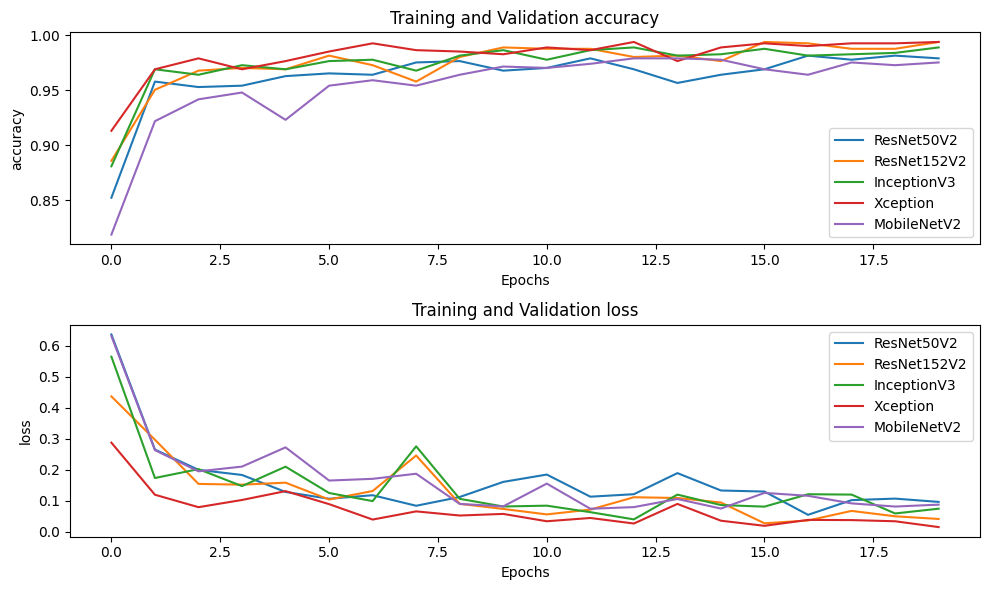

In [ ]:
# @title Visually analysing the performance of different Tansfer Learning Models
import matplotlib.pyplot as plt

# Define the metrics to plot (e.g., 'accuracy' and 'loss')
metrics_to_plot = ['accuracy', 'loss']

# Create subplots for each metric
fig, axes = plt.subplots(len(metrics_to_plot), 1, figsize=(10, 6))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)  # Create subplots for each metric
    for idx, history in enumerate(HISTORIES):
        plt.plot(history[metric], label=TL_Models_NAMES[idx])
    plt.title(f'Training and Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()


<p><b>Visual Inference</b>: All training models had similar performance, but the red line depicts the best validation accuracy coupled with least validation loss. As a result, we will be using Xception model to train our model</p>

In [ ]:
# @title Get the weights from DenseNet121
base_model = Xception(weights='imagenet', include_top=False, input_shape=(images_size, images_size, 3))

<p> ImageNet is a large-scale visual database designed for use in visual object recognition and image classification research. It has been a central resource for developing and benchmarking computer vision algorithms. ImageNet has been widely used for pre-training deep neural networks for image-related tasks. Pre-trained models on ImageNet weights are often used as a starting point for transfer learning in various computer vision applications. Models pre-trained on ImageNet have learned rich feature representations that can be valuable for image classification.</p>

In [ ]:
# @title Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# @title Training the Model
model = tf.keras.models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),

    layers.Flatten(),

    layers.Dense(256,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4,activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                        

In [ ]:
# @title Setting the optimizers
from tensorflow.keras import optimizers

optimizer = optimizers.Adam(learning_rate=learning_rate_schedule)

model.compile(optimizer=optimizer,
             loss="categorical_crossentropy",
              metrics=['accuracy']
             )

In [ ]:
# @title Applying Model to Validation Set
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=valid_generator,
    batch_size=batch_size,
    validation_steps=valid_generator.samples // batch_size,
    callbacks=[callback]
)

Epoch 1/20
92/92 [==============================] - 372s 4s/step - loss: 1.1164 - accuracy: 0.8986 - val_loss: 3.1292e-07 - val_accuracy: 1.0000 - lr: 0.0094
Epoch 2/20
92/92 [==============================] - 364s 4s/step - loss: 0.3723 - accuracy: 0.9418 - val_loss: 7.2491e-04 - val_accuracy: 1.0000 - lr: 0.0088
Epoch 3/20
92/92 [==============================] - 362s 4s/step - loss: 0.1728 - accuracy: 0.9562 - val_loss: 3.7521e-04 - val_accuracy: 1.0000 - lr: 0.0083
Epoch 4/20
92/92 [==============================] - 369s 4s/step - loss: 0.1586 - accuracy: 0.9521 - val_loss: 0.0032 - val_accuracy: 1.0000 - lr: 0.0078
Epoch 5/20
92/92 [==============================] - 368s 4s/step - loss: 0.1926 - accuracy: 0.9507 - val_loss: 3.2699e-04 - val_accuracy: 1.0000 - lr: 0.0073
Epoch 6/20
92/92 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9493
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0034127342514693737.
92/92 [==============================] - 370

<p>We notice that all iterations yielded 100% success rate on our validation set (<b>val_accuracy: 1.0000</b>). We can therefore conclude that our model is effective. However, this test has been done only on a small sample size of 20 images (5 images per class). Now, we must test the effectiveness on a larger test set. Therefore, we will now perform the similar operation on our test set of 200 images. (50 per class)</p>

In [ ]:
# @title Evaluating the test dataset
score = model.evaluate(test_generator, verbose=False)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.5852165818214417
Test accuracy: 0.9300000071525574


1/1 [==============================] - 1s 1s/step


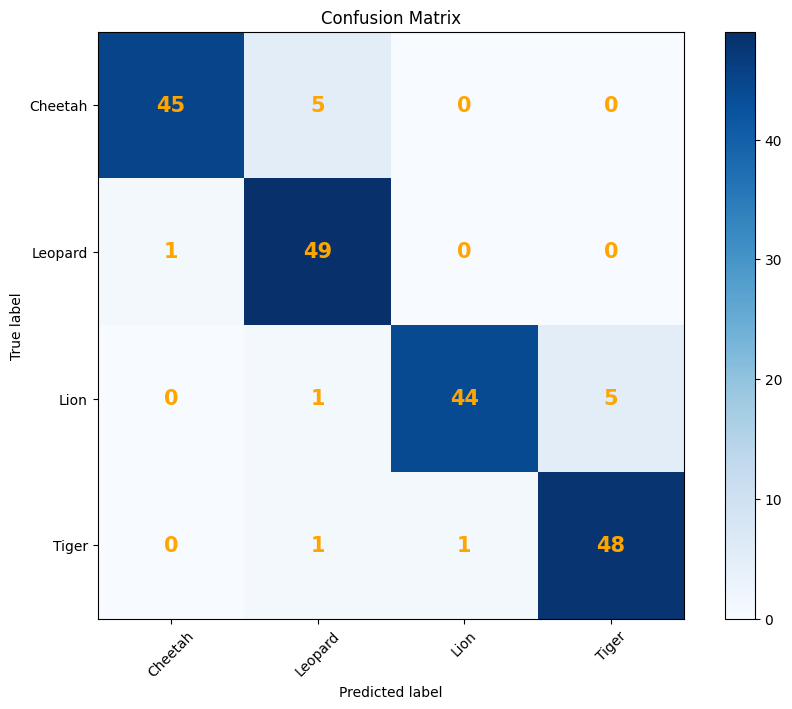

In [ ]:
# @title Analysing Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

true_labels = []
predicted_labels = []

num_batches = len(test_generator)
for i in range(num_batches):
    x_batch, y_batch = test_generator[i]
    predictions = model.predict(x_batch)
    true_labels.extend(np.argmax(y_batch, axis=1))  # Convert one-hot encoded labels to class indices
    predicted_labels.extend(np.argmax(predictions, axis=1))

class_names = test_generator.class_indices.keys()

# Calculate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(9, 7))
# Create a visualization of the confusion matrix with counts
plt.imshow(confusion, interpolation='nearest', cmap=plt.get_cmap('Blues'))

# Add counts to the confusion matrix plot
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion[i, j]), horizontalalignment='center', verticalalignment='center',color='orange', fontsize=15, weight='bold')

plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


### <b>Confusion Matrix</b>

<p>A confusion matrix is a table used in classification tasks to evaluate the performance of a machine learning model. It compares the predicted values of a model with the actual values and provides a summary of the model's performance in terms of true positives (correctly predicted positive instances), true negatives (correctly predicted negative instances), false positives (incorrectly predicted positive instances), and false negatives (incorrectly predicted negative instances). The matrix is organized into four quadrants, and each cell represents a specific combination of predicted and actual outcomes, allowing for a detailed analysis of the model's accuracy, precision, recall, and other performance metrics.</p>

<p><b>Inference</b>: We were able to get good accuracy on all the wild cats classes. Our model however, wasn't perfectly accurate while classifying cheetahs (mistook 5 cheetah images and classified them as leopards) and lions (mistook 5 lion images and classified then as tigers). Overall, our model performed well with a 93% success rate.

In [ ]:
# @title Analysing Classification Report
# Calculate the classification report
report = classification_report(true_labels, predicted_labels, target_names=test_generator.class_indices)

# Print the classification report
print(report)

              precision    recall  f1-score   support

     Cheetah       0.98      0.90      0.94        50
     Leopard       0.88      0.98      0.92        50
        Lion       0.98      0.88      0.93        50
       Tiger       0.91      0.96      0.93        50

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



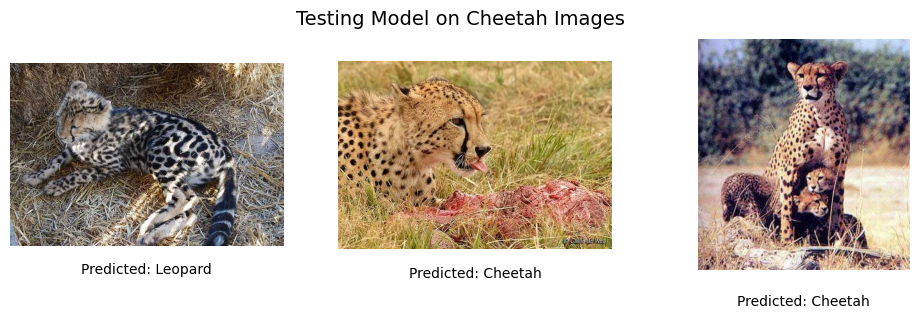

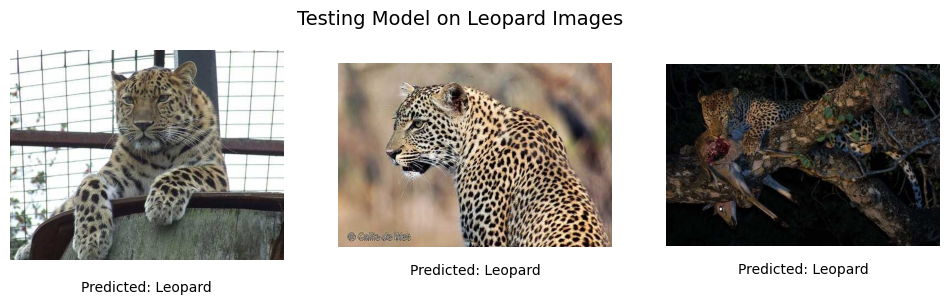

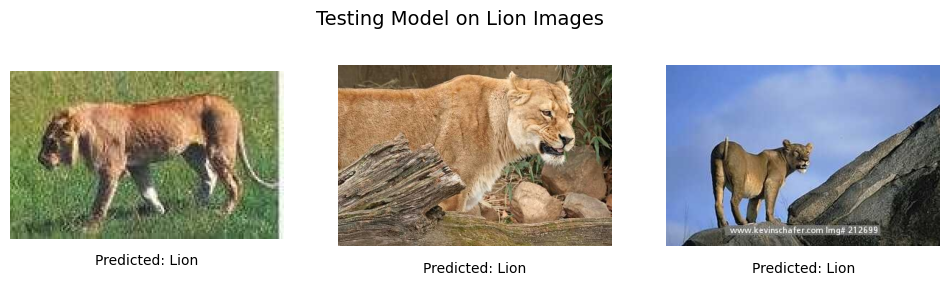

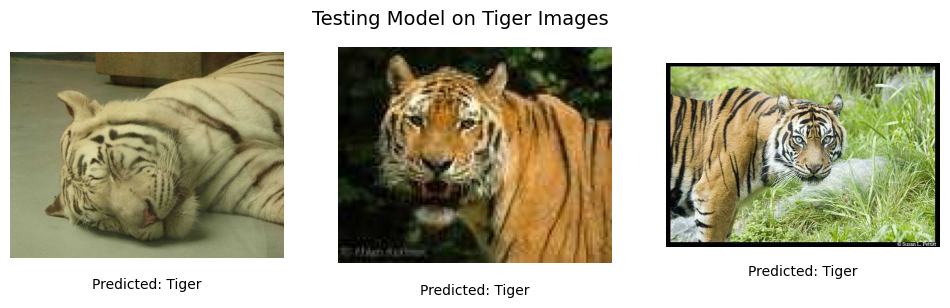

In [ ]:
# @title Visual Representation of Model Performance
import contextlib
def test_and_display_images(image_folder, class_name):
    contents = os.listdir(image_folder)
    random_contents = random.sample(contents, min(3, len(contents)))
    random_contents_list = [image_folder + '/' + str(i) for i in random_contents]

    plt.figure(figsize=(12, 3))
    for i, j in enumerate(random_contents_list):
        plt.subplot(1, 3, i + 1)
        img = mpimg.imread(j)
        plt.imshow(img)
        plt.axis('off')

        img2 = image.load_img(j, target_size=(224, 224))
        img_array = image.img_to_array(img2)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Rescale pixel values to [0, 1]

        prediction = model.predict(img_array)
        predicted_label = np.argmax(prediction)
        predicted_class = class_names[predicted_label]

        # Display predicted class below the image
        plt.text(0.5, -0.15, f'Predicted: {predicted_class}', size=10, ha="center", transform=plt.gca().transAxes)

    plt.suptitle(f'Testing Model on {class_name} Images', fontsize=14)
    plt.show()

# Test and display images for each class without processing statements
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        test_and_display_images('/content/drive/MyDrive/CNN_Project_Images/Test/Cheetah', 'Cheetah')
        test_and_display_images('/content/drive/MyDrive/CNN_Project_Images/Test/Leopard', 'Leopard')
        test_and_display_images('/content/drive/MyDrive/CNN_Project_Images/Test/Lion', 'Lion')
        test_and_display_images('/content/drive/MyDrive/CNN_Project_Images/Test/Tiger', 'Tiger')


## <b>Conclusion</b>
<p>In conclusion, this project demonstrated the successful implementation of a CNN model for classifying wild cat species. We were able to analyse the predictive power of different Transfer Learning models. The visualization of predictions provides further valuable insights into the model's performance. Overall, our model yielded a strong predictive accuracy of 93%.</p>